In [1]:
import pandas as pd
import os
from caveclient import CAVEclient
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nglui.statebuilder import *
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [2]:
client = CAVEclient()

if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [3]:
feco_df_all = client.materialize.query_table('feco_axons_v0')
feco_df_all = feco_df_all[feco_df_all.classification_system == 'T1L']

In [4]:
def filt_syn_df(syn_df, syn_thresh):
    
    indices_to_include = []

    # Find unique presynaptic neurons
    unique_pre_ids = syn_df.pre_pt_root_id.unique().tolist()

    # Loop through presynaptic neurons
    for i in unique_pre_ids:       
        pre_df = syn_df[syn_df.pre_pt_root_id == i]
        # Find unique postsynaptic neurons targeted by i-th presynaptic neuron
        unique_post_ids = pre_df.post_pt_root_id.unique().tolist() 
        # Loop through postsynaptic neurons
        for j in unique_post_ids:    
            # Is number of synapses onto j-th postsynaptic neuron larger than or equal to syn_thresh? 
            if sum(pre_df.post_pt_root_id == j) >= syn_thresh: 
                # Get indices (rows)
                indices = pre_df.index.values[pre_df.post_pt_root_id == j]       
                # Loop through indices 
                for k in indices:
                    # Append each index separately to avoid lists within list
                    indices_to_include.append(k)

    # Sort indices in ascending order
    indices_to_include.sort()
    
    # Create new syn_df with only connections above syn_thresh
    syn_df_filt = syn_df.loc[indices_to_include]
    
    return syn_df_filt

In [5]:
upstream = False
syn_thresh = 4
# inputs = np.intersect1d(a, b)
inputs = feco_df_all.pt_root_id.tolist()
# inputs = asc.pt_root_id.tolist()
if upstream == True:
    syn_df = client.materialize.synapse_query(post_ids = inputs)
else:
    syn_df = client.materialize.synapse_query(pre_ids = inputs)

synapse_df = filt_syn_df(syn_df, syn_thresh)
synapse_df

,id,created,superceded_id,valid,score,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position
0,12347226,2022-11-17 14:28:59.843347+00:00,NaN,t,23,72553681551362367,648518346508752447,72553681551364124,648518346496052070,"[15711, 104803, 3127]","[15725, 104811, 3129]"
2,42127599,2022-11-17 14:28:59.843347+00:00,NaN,t,23,72342781074735265,648518346480125925,72342781074737829,648518346502617767,"[9275, 110693, 2403]","[9251, 110663, 2404]"
8,42127679,2022-11-17 14:28:59.843347+00:00,NaN,t,26,72342781074751920,648518346480125925,72342781074771140,648518346489566297,"[9325, 110663, 2408]","[9323, 110625, 2409]"
17,42127880,2022-11-17 14:28:59.843347+00:00,NaN,t,19,72342781074677182,648518346480666625,72342781074669821,648518346489566297,"[9535, 110905, 2377]","[9537, 110885, 2376]"
19,42127884,2022-11-17 14:28:59.843347+00:00,NaN,t,18,72342781074853464,648518346480125925,72342781074866617,648518346465266805,"[9509, 110697, 2438]","[9543, 110695, 2439]"
...,...,...,...,...,...,...,...,...,...,...,...
46465,40344519,2022-11-17 14:28:59.843347+00:00,NaN,t,24,72413149952820103,648518346514361543,72413149952931331,648518346502916595,"[10997, 112117, 2575]","[11033, 112121, 2577]"
46466,40344517,2022-11-17 14:28:59.843347+00:00,NaN,t,33,72413149952955202,648518346514361543,72413149952922244,648518346489565548,"[11013, 112025, 2579]","[11029, 111997, 2579]"
46467,40553999,2022-11-17 14:28:59.843347+00:00,NaN,t,57,72623706563962620,648518346487912272,72623706563955920,648518346490196954,"[17855, 95375, 2861]","[17823, 95369, 2862]"
46473,40553881,2022-11-17 14:28:59.843347+00:00,NaN,t,18,72623706564104241,648518346474593218,72623706564125980,648518346507389983,"[17589, 96255, 2930]","[17577, 96221, 2931]"


In [ ]:
# per feco neuron, count the number of unique postsynaptic neurons 
# and the synapses formed 
neurons = [] 
neurons_all = [] 
id = [] 

for idx in feco_df_all.pt_root_id.unique(): 
    if upstream == False:  
        neurons.append(len(synapse_df[synapse_df.pre_pt_root_id == idx].post_pt_root_id.unique())) 
        id.append(idx)
    else: 
        neurons.append(len(synapse_df[synapse_df.post_pt_root_id == idx].pre_pt_root_id.unique())) 
        id.append(idx)

synapses = [] 

for idx in feco_df_all.pt_root_id.unique(): 
    synapses.append(len(synapse_df[synapse_df.post_pt_root_id == idx]))

pre_neurons = pd.DataFrame() 
pre_neurons['id'] = id 
pre_neurons['pre_neurons'] = neurons
pre_neurons['synapses'] = synapses

# get number of synapses 
# generate syn per conn and plot distribution of synapses 

In [ ]:
# per feco neuron, count the number of unique postsynaptic neurons 
# and the synapses formed 
neurons = [] 
neurons_all = [] 
id = [] 

for idx in feco_df_all.pt_root_id.unique(): 
    if upstream == False:  
        neurons.append(len(synapse_df[synapse_df.pre_pt_root_id == idx].post_pt_root_id.unique())) 
        id.append(idx)
    else: 
        neurons.append(len(synapse_df[synapse_df.post_pt_root_id == idx].pre_pt_root_id.unique())) 
        id.append(idx)

synapses = [] 

for idx in feco_df_all.pt_root_id.unique(): 
    synapses.append(len(synapse_df[synapse_df.pre_pt_root_id == idx]))

post_neurons = pd.DataFrame() 
post_neurons['id'] = id 
post_neurons['post_neurons'] = neurons
post_neurons['synapses'] = synapses

# get number of synapses 
# generate syn per conn and plot distribution of synapses 

In [8]:
# create dataframe - separate by feco type (claw, hook, club)

# find presynaptic neurons, postsynaptic neurons, 
# presynapses, postsynapses per neuron 

claw_ext = feco_df_all[(feco_df_all.classification_system == 'T1L') & (feco_df_all.cell_type.str.contains('claw_ext'))]

claw_flx = feco_df_all[(feco_df_all.classification_system == 'T1L') & (feco_df_all.cell_type.str.contains('claw_flx'))]

hook_ext = feco_df_all[(feco_df_all.classification_system == 'T1L') & (feco_df_all.cell_type.str.contains('hook_ext'))]

hook_flx = feco_df_all[(feco_df_all.classification_system == 'T1L') & (feco_df_all.cell_type.str.contains('hook_flx'))]

club = feco_df_all[(feco_df_all.classification_system == 'T1L') & (feco_df_all.cell_type.str.contains('club'))]


In [9]:
cell_type = [] 

for idx in pre_neurons.id.tolist(): 
    if idx in claw_ext.pt_root_id.tolist(): 
        cell_type.append('claw_ext')
        
    if idx in claw_flx.pt_root_id.tolist(): 
        cell_type.append('claw_flx')
        
    if idx in hook_ext.pt_root_id.tolist(): 
        cell_type.append('hook_ext')
        
    if idx in hook_flx.pt_root_id.tolist(): 
        cell_type.append('hook_flx')
        
    if idx in club.pt_root_id.tolist(): 
        cell_type.append('club')

In [10]:
pre_neurons['cell_type'] = cell_type

In [11]:
cell_type = [] 

for idx in post_neurons.id.tolist(): 
    if idx in claw_ext.pt_root_id.tolist(): 
        cell_type.append('claw_ext')
        
    if idx in claw_flx.pt_root_id.tolist(): 
        cell_type.append('claw_flx')
        
    if idx in hook_ext.pt_root_id.tolist(): 
        cell_type.append('hook_ext')
        
    if idx in hook_flx.pt_root_id.tolist(): 
        cell_type.append('hook_flx')
        
    if idx in club.pt_root_id.tolist(): 
        cell_type.append('club')

In [12]:
post_neurons['cell_type'] = cell_type

In [146]:
# pre_neurons.to_csv('pre_neurons.csv')

In [147]:
# post_neurons.to_csv('post_neurons.csv')

Text(0, 0.5, 'presynaptic neurons')

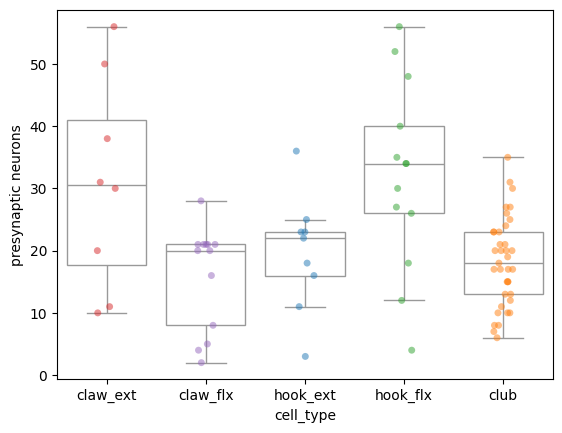

In [14]:
sns.stripplot(x='cell_type', y='pre_neurons', order = ["claw_ext","claw_flx", "hook_ext", "hook_flx", "club"], data=pre_neurons, jitter=True, alpha = 0.5, hue = "cell_type")
sns.boxplot(x = 'cell_type', y = 'pre_neurons', order = ["claw_ext","claw_flx", "hook_ext", "hook_flx", "club"],data = pre_neurons, color = 'w', showfliers = False)
plt.ylabel('presynaptic neurons')
# plt.savefig('feco_preneurons.pdf', format='pdf', dpi=1200, bbox_inches = 'tight')

Text(0, 0.5, 'synapses')

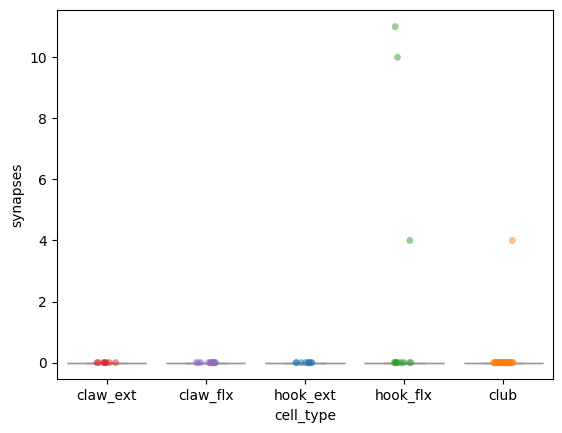

In [15]:
sns.stripplot(x='cell_type', y='synapses', order = ["claw_ext","claw_flx", "hook_ext", "hook_flx", "club"], data=pre_neurons, jitter=True, alpha = 0.5, hue = "cell_type")
sns.boxplot(x = 'cell_type', y = 'synapses', order = ["claw_ext","claw_flx", "hook_ext", "hook_flx", "club"],data = pre_neurons, color = 'w', showfliers = False)
plt.ylabel('synapses')
# plt.savefig('feco_presynapses.pdf', format='pdf', dpi=1200, bbox_inches = 'tight')

(0.0, 60.0)

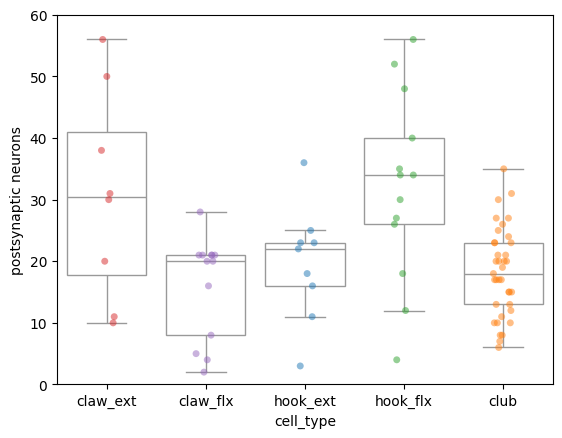

In [16]:
sns.stripplot(x='cell_type', y='post_neurons', order = ["claw_ext","claw_flx", "hook_ext", "hook_flx", "club"], data=post_neurons, jitter=True, alpha = 0.5, hue = "cell_type")
sns.boxplot(x = 'cell_type', y = 'post_neurons', order = ["claw_ext","claw_flx", "hook_ext", "hook_flx", "club"],data = post_neurons, color = 'w', showfliers = False)
plt.ylabel('postsynaptic neurons')
plt.ylim([0, 60])
# plt.savefig('feco_postneurons.pdf', format='pdf', dpi=1200, bbox_inches = 'tight')

(0.0, 500.0)

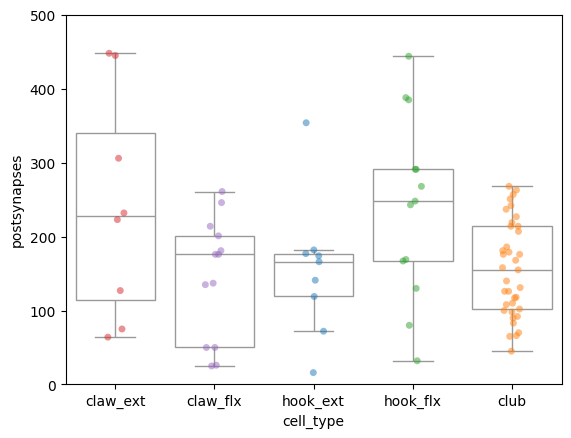

In [17]:
sns.stripplot(x='cell_type', y='synapses', order = ["claw_ext","claw_flx", "hook_ext", "hook_flx", "club"], data=post_neurons, jitter=True, alpha = 0.5, hue = "cell_type")
sns.boxplot(x = 'cell_type', y = 'synapses', order = ["claw_ext","claw_flx", "hook_ext", "hook_flx", "club"],data = post_neurons, color = 'w', showfliers = False)
plt.ylabel('postsynapses')
plt.ylim([0, 500])
# plt.savefig('feco_postsynapses.pdf', format='pdf', dpi=1200, bbox_inches = 'tight')